# MiniDatathonF5: USA Covid 19

## Problema
¿Cómo han evolucionado los casos confirmados, muertes y hospitalizaciones por COVID-19 del 2020 al 2021 en los distintos estados de USA?

## 1.Importar y limpiar datos



### 1.1. Importar los datos

In [1]:
# Importar bibliotecas
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# Obteniendo datos
response = requests.get("https://api.covidtracking.com/v1/states/daily.json")
if response.status_code == 200:
    data = response.json()
    print("Se guardo el contenido.")
else:
    print("Error al obtener data")

Se guardo el contenido.


El dataset contine un total de 56 campos, de los cuales muchos de estos no seran de utilidad para el problema a analizar.

Se hizo una selección de datos que nos serán relevantes para el analisis.

*   **date**, fechar en que los datos fueron recopilados.
*   **state**, estado o territorio (dos letra).
*   **positive**, número total de casos confirmados más probables de COVID-19.
*   **positiveIncrease**, aumento diarío de los positivos del campo *positive*.
*   **death**, total de víctimas mortales con diagnóstico de COVID-19 confirmados o probables.
*   **deathIncrease**, aumento diario de la mortalidad, calculado del valor del día anterior.
*   **hospitalizedCurrently**, Número actual de hospitalizados con COVID-19.
*   **hospitalizedIncrease**, Número de hospitalizaciones diarias, calculadas del calor del día anterior.



In [22]:
# Lista de las columnas seleccionadas para el analisis
columns_select = [
    'date', 'state', 'positive', 'positiveIncrease', 'death',
    'deathIncrease', 'hospitalizedCurrently', 'hospitalizedIncrease'
]

# Pasarlos a un dataframe
df = pd.DataFrame(data, columns=columns_select)
df

,date,state,positive,positiveIncrease,death,deathIncrease,hospitalizedCurrently,hospitalizedIncrease
0,20210307,AK,56886.0,0,305.0,0,33.0,0
1,20210307,AL,499819.0,408,10148.0,-1,494.0,0
2,20210307,AR,324818.0,165,5319.0,22,335.0,11
3,20210307,AS,0.0,0,0.0,0,NaN,0
4,20210307,AZ,826454.0,1335,16328.0,5,963.0,44
...,...,...,...,...,...,...,...,...
20775,20200117,WA,0.0,0,NaN,0,NaN,0
20776,20200116,WA,0.0,0,NaN,0,NaN,0
20777,20200115,WA,0.0,0,NaN,0,NaN,0
20778,20200114,WA,0.0,0,NaN,0,NaN,0


In [23]:
# Dimensión del dataframe
df.shape

(20780, 8)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20780 entries, 0 to 20779
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   20780 non-null  int64  
 1   state                  20780 non-null  object 
 2   positive               20592 non-null  float64
 3   positiveIncrease       20780 non-null  int64  
 4   death                  19930 non-null  float64
 5   deathIncrease          20780 non-null  int64  
 6   hospitalizedCurrently  17339 non-null  float64
 7   hospitalizedIncrease   20780 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 1.3+ MB


Se puede observar que hay una cantidad considerable de datos nulos.

### 1.2. Limpiar datos

Se va a identificar y corregir errores, inconsistencias y valores atípicos.

In [30]:
# Formatear el campo de fecha (date)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.sort_values(by=['state'])
df.head(3)

,date,state,positive,positiveIncrease,death,deathIncrease,hospitalizedCurrently,hospitalizedIncrease
0,2021-03-07,AK,56886.0,0,305.0,0,33.0,0
1,2021-03-07,AL,499819.0,408,10148.0,-1,494.0,0
2,2021-03-07,AR,324818.0,165,5319.0,22,335.0,11


#### Manejar los valores nulos
Los campos donde se tienen valores nulos son los siguientes: positive, death y hospitalizedCurrently.

Para saber que opcion de imputación utilizar, se va a realizar la prueba de normalidad **Shapiro**, sí es una distribución normal (menor a 0.05), se va a imputar con la media, en caso contrario se aplicara la mediana.

In [32]:
from scipy import stats

In [49]:
col_num = ['positive', 'death', 'hospitalizedCurrently']
def test_normal(col):
    data = df[col].dropna()
    stat, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return True
    else:
        return False

def manage_null():
    for col in col_num:
        if test_normal(col):
            df[col].fillna(df[col].mean(), inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

manage_null()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20780.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20780.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20780.
  res = hypotest_fun_out(*samples, **kwds)


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20780 entries, 0 to 20779
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   20780 non-null  datetime64[ns]
 1   state                  20780 non-null  object        
 2   positive               20780 non-null  float64       
 3   positiveIncrease       20780 non-null  int64         
 4   death                  20780 non-null  float64       
 5   deathIncrease          20780 non-null  int64         
 6   hospitalizedCurrently  20780 non-null  float64       
 7   hospitalizedIncrease   20780 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 1.3+ MB


## 2. Gráficos

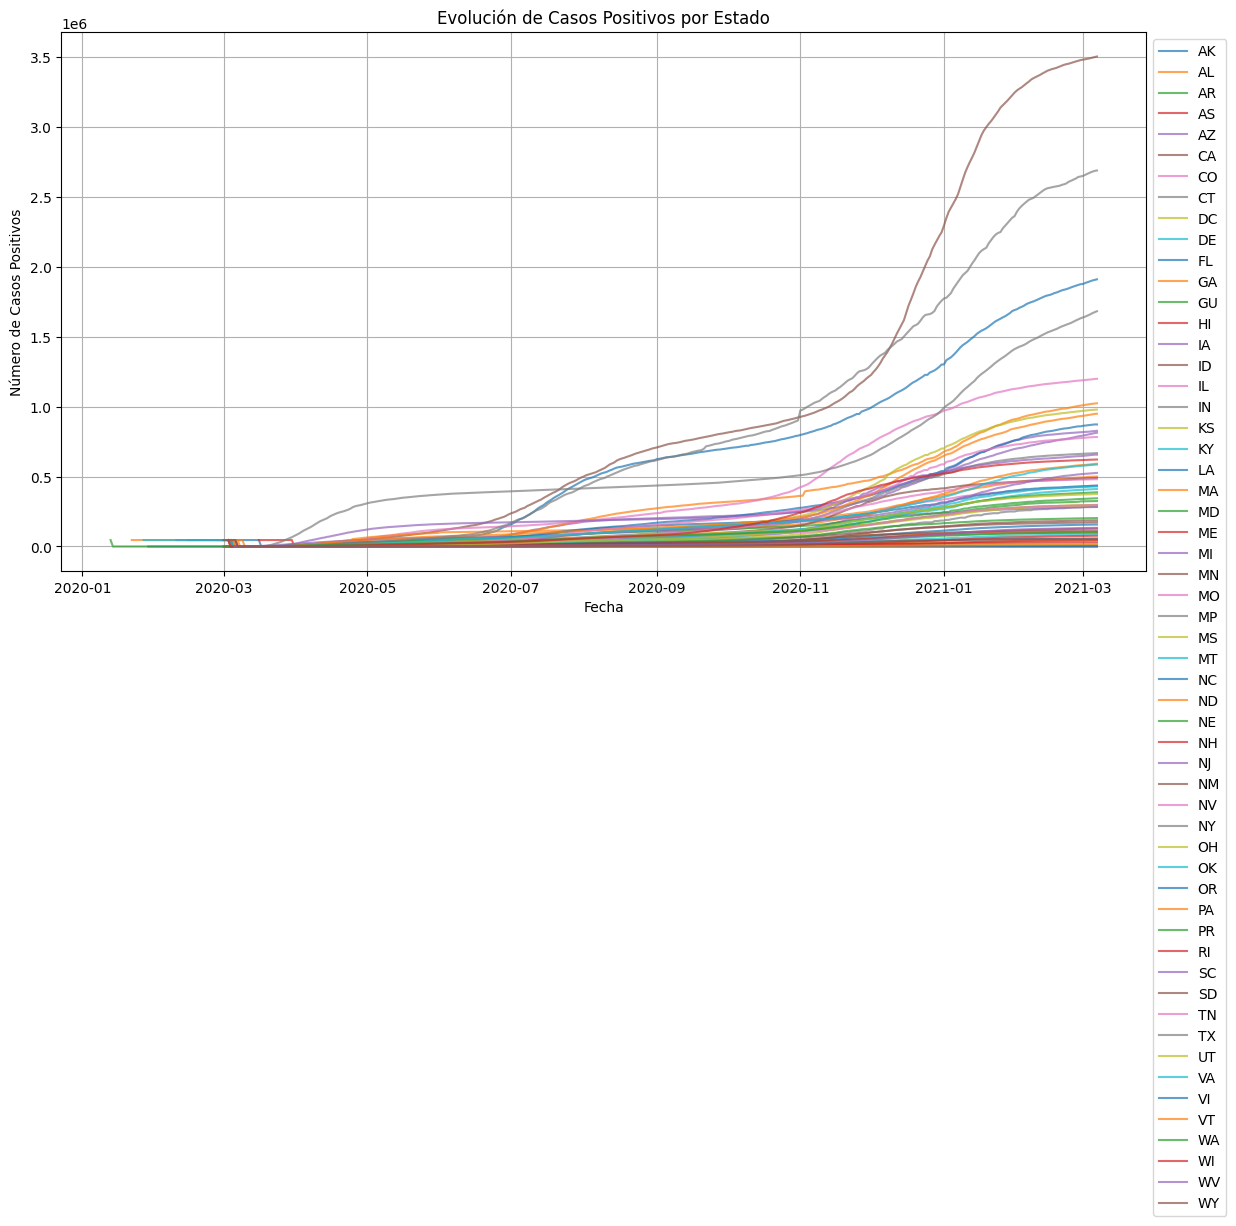

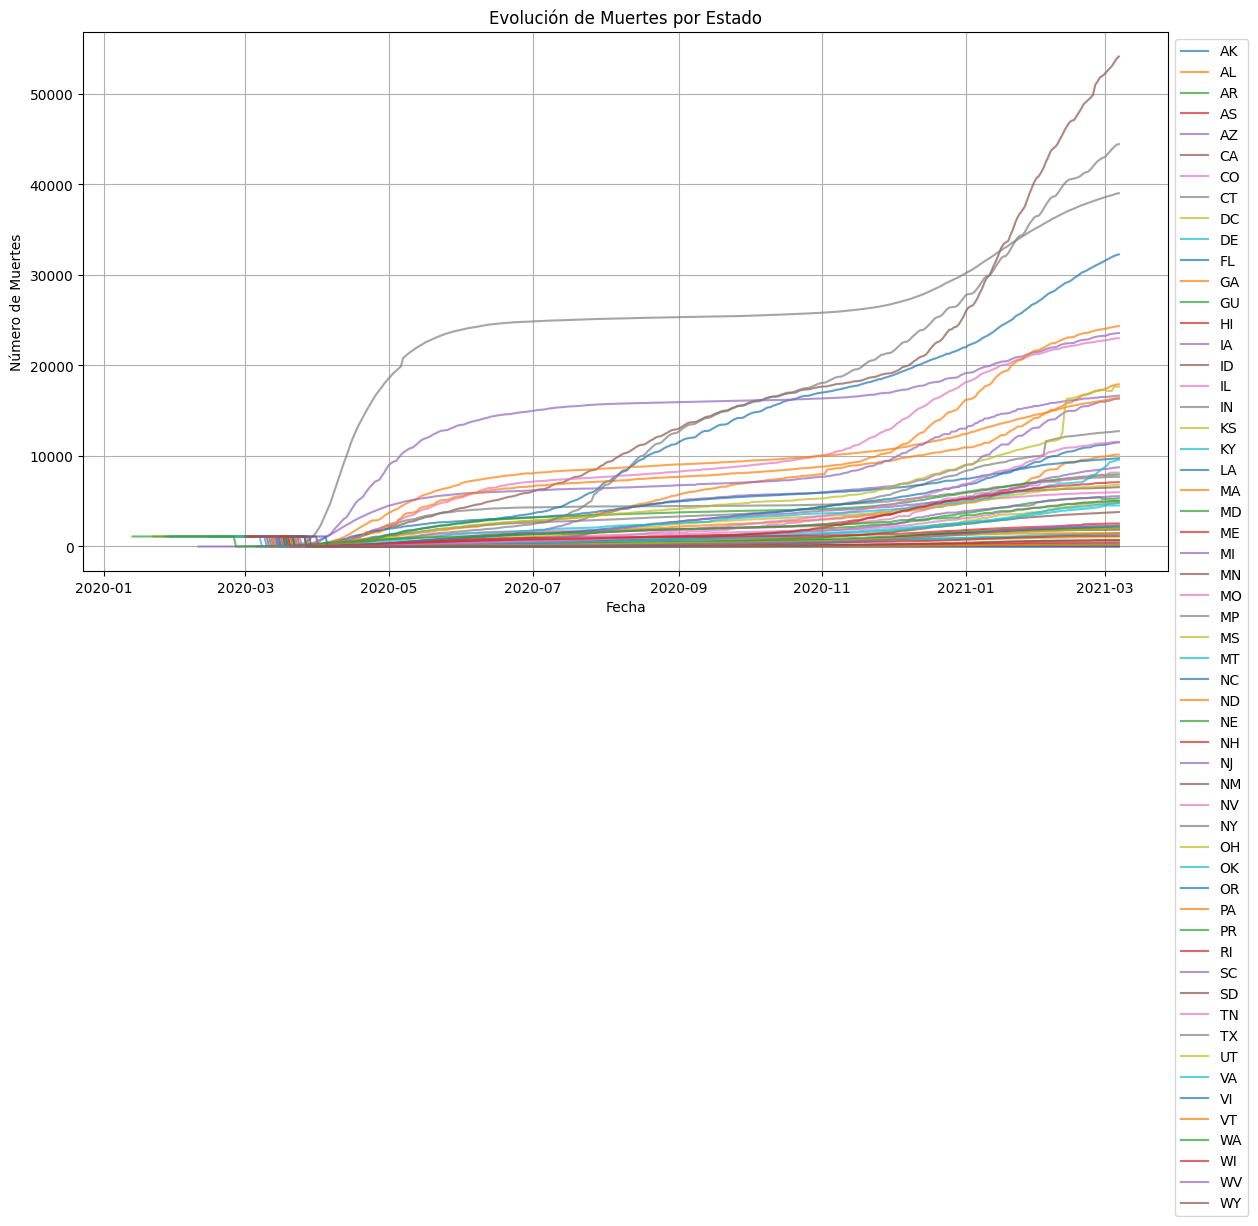

In [59]:
# Gráfico de líneas para casos positivos
plt.figure(figsize=(14, 7))
for state in df['state'].unique():
    state_data = df[df['state'] == state]
    plt.plot(state_data['date'], state_data['positive'], label=state, alpha=0.7)
plt.title('Evolución de Casos Positivos por Estado')
plt.xlabel('Fecha')
plt.ylabel('Número de Casos Positivos')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

# Gráfico de líneas para muertes
plt.figure(figsize=(14, 7))
for state in df['state'].unique():
    state_data = df[df['state'] == state]
    plt.plot(state_data['date'], state_data['death'], label=state, alpha=0.7)
plt.title('Evolución de Muertes por Estado')
plt.xlabel('Fecha')
plt.ylabel('Número de Muertes')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

## 3. Análisis estadístico descriptivo

In [56]:
df.describe()

,date,positive,positiveIncrease,death,deathIncrease,hospitalizedCurrently,hospitalizedIncrease
count,20780,2.078000e+04,20780.000000,20780.000000,20780.000000,20780.000000,20780.000000
mean,2020-09-02 18:13:30.779595776,1.640785e+05,1383.849519,3576.919249,24.790712,1081.356352,37.360780
min,2020-01-13 00:00:00,0.000000e+00,-7757.000000,0.000000,-201.000000,0.000000,-12257.000000
25%,2020-06-02 00:00:00,5.905750e+03,65.000000,183.000000,0.000000,225.000000,0.000000
50%,2020-09-03 00:00:00,4.606450e+04,435.000000,1108.000000,6.000000,531.000000,0.000000
75%,2020-12-05 00:00:00,1.756140e+05,1335.250000,4159.000000,24.000000,1051.000000,36.000000
max,2021-03-07 00:00:00,3.501394e+06,71734.000000,54124.000000,2559.000000,22851.000000,16373.000000
std,NaN,3.254990e+05,3023.558742,6172.645333,60.162742,1897.660439,208.237151


## 4. Correlación y análisis de variables

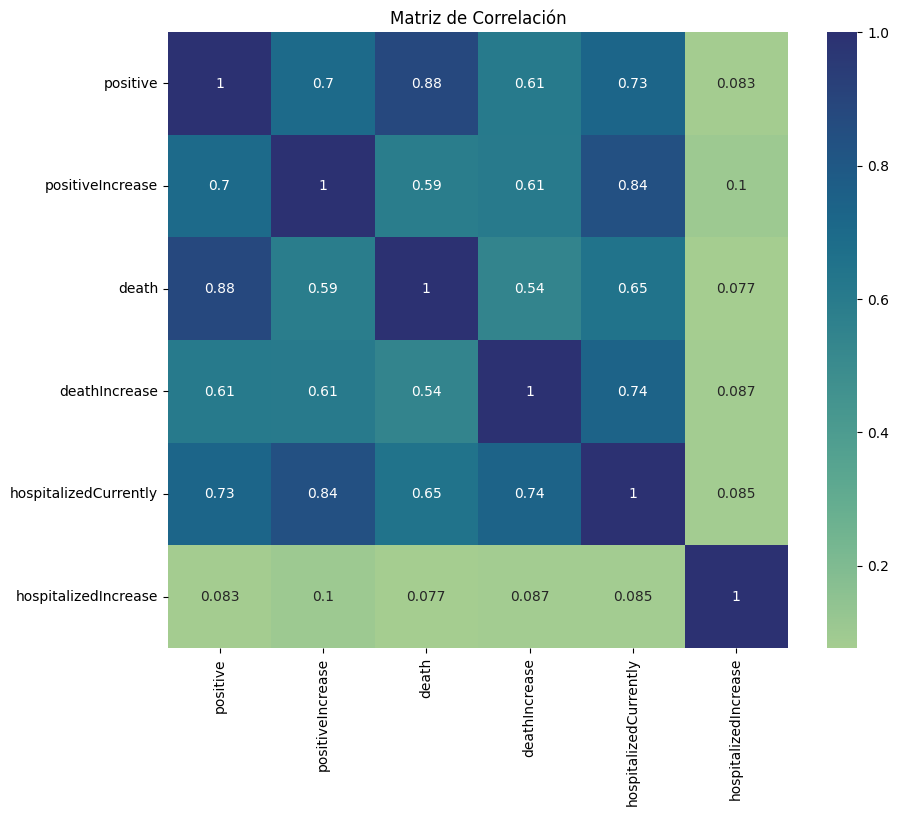

In [53]:
# Seleccionamos las columnas de tipo numérico
num_cols = df.select_dtypes(include=[np.number]).columns
num_df = df[num_cols]

# Se realiza la matriz de correlación
corr_matrix = num_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='crest')
plt.title('Matriz de Correlación')
plt.show()